In [87]:
import numpy as np
import pandas as pd
import rasterio as rio
import matplotlib.pyplot as plt
import l2a_runner
import os
import json

### Define Product Locations and options

In [88]:
resolution = 60

base_l2a_dir = "/scratch/toml/sentinel_2_data/reports"
report_dir = f"{base_l2a_dir}/TEST5"

base_l1c_dir = "/scratch/toml/sentinel_2_data/locations"

locs = {
    "CH": "S2A_MSIL1C_20230903T101601_N0509_R065_T32TMS_20230903T140124.SAFE",
    "BRA": "S2A_MSIL1C_20230909T141721_N0509_R010_T21MTS_20230909T192148.SAFE",
    'ALG' : 'S2B_MSIL1C_20230904T103629_N0509_R008_T30RXT_20230904T125735.SAFE'
}
locations = {}
for loc_name, loc_path in locs.items():
    loc_product_description = loc_path.split(".")
    if loc_product_description[-1] != "SAFE":
        raise ValueError(
            f"Invalid product description: {loc_product_description}. Expected SAFE file"
        )
    (
        misssion_id,
        product_level,
        date_take,
        processing_baseline,
        orbit_number,
        tile,
        product_discriminator,
    ) = loc_product_description[0].split("_")

    locations[loc_name] = {
        "loc_name": loc_name,
        "l1c_product_name": loc_product_description[0],
        "l1c_path": f"{base_l1c_dir}/{loc_name}/{loc_path}",
        "mission_id": misssion_id,
        "date_take": date_take,
        "processing_baseline": processing_baseline,
        "orbit_number": orbit_number,
        "tile": tile,
        "product_discriminator": product_discriminator.split(".")[0],
    }

### Define modifications

In [89]:
# NO_DATA, SATURATED_OR_DEFECTIVE, CASTED_SHADOWS, CLOUD_SHADOWS, VEGETATION, NOT_VEGETATED, WATER, UNCLASSIFIED, CLOUD_MEDIUM_PROBABILITY, CLOUD_HIGH_PROBABILITY, THIN_CIRRUS, SNOW
SC_const_labels = [
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '0',
    #     'info' : 'Set whole SCL layer to NO_DATA',
    #     'name' : 'class_NO_DATA'
    # },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '1',
    #     'info' : 'Set whole SCL layer to SATURATED_OR_DEFECTIVE',
    #     'name' : 'class_SATURATED_OR_DEFECTIVE'
    # },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '2',
    #     'info' : 'Set whole SCL layer to CASTED_SHADOWS',
    #     'name' : 'class_CASTED_SHADOWS'
    # },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "3",
        "info": "Set whole SCL layer to CLOUD_SHADOWS",
        "name": "class_CLOUD_SHADOWS",
    },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "4",
        "info": "Set whole SCL layer to VEGETATION",
        "name": "class_VEGETATION",
    },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '5',
    #     'info' : 'Set whole SCL layer to NOT_VEGETATED',
    #     'name' : 'class_NOT_VEGETATED'
    # },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '6',
    #     'info' : 'Set whole SCL layer to WATER',
    #     'name' : 'class_WATER'
    # },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '7',
        'info' : 'Set whole SCL layer to UNCLASSIFIED',
        'name' : 'class_UNCLASSIFIED'
    },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '8',
    #     'info' : 'Set whole SCL layer to CLOUD_MEDIUM_PROBABILITY',
    #     'name' : 'class_CLOUD_MEDIUM_PROBABILITY'
    # },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '9',
    #     'info' : 'Set whole SCL layer to CLOUD_HIGH_PROBABILITY',
    #     'name' : 'class_CLOUD_HIGH_PROBABILITY'
    # },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '10',
    #     'info' : 'Set whole SCL layer to THIN_CIRRUS',
    #     'name' : 'class_THIN_CIRRUS'
    # },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '11',
    #     'info' : 'Set whole SCL layer to SNOW',
    #     'name' : 'class_SNOW'
    # },
]

### Create modified L2A products

In [90]:
data_info = {}
data_info["reference"] = []
for loc_name, loc_dict in locations.items():
    mod_name = "reference"
    print(f"Running {loc_name}: {mod_name}")
    output_dir = f"{report_dir}/{loc_name}/{mod_name}"

    if os.path.isdir(output_dir):
            print(f"{loc_name}: {mod_name} already exists. Skipping...")
    else:
        os.makedirs(output_dir, exist_ok=True)

        runner = l2a_runner.L2A_process_runner(
            loc_dict["l1c_path"], output_dir, resolution=resolution
        )
        runner.run()

    info_dict = {
        "name": f"{loc_name}_{mod_name}",
        "loc": loc_dict,
        "mod": None,
        "output_dir": output_dir,
    }
    data_info["reference"].append(info_dict)


data_info["modified"] = []
for mod in SC_const_labels:
    for loc_name, loc_dict in locations.items():
        mod_flag = mod["flag"]
        mod_val = mod["value"]
        mod_name = mod["name"]

        print(f"Running {loc_name}: {mod_name}")
        output_dir = f"{report_dir}/{loc_name}/{mod_name}"
        if os.path.isdir(output_dir):
            print(f"{loc_name}: {mod_name} already exists. Skipping...")
        else:
            os.makedirs(output_dir, exist_ok=True)

            os.environ[mod_flag] = mod_val
            runner = l2a_runner.L2A_process_runner(
                loc_dict["l1c_path"], output_dir, resolution=resolution
            )
            runner.run()
            os.environ.pop(mod_flag, None)

        info_dict = {
            "name": f"{loc_name}_{mod_name}",
            "loc": loc_dict,
            "mod": mod,
            "output_dir": output_dir,
        }
        data_info["modified"].append(info_dict)

        print(f"Running {loc_name}: {mod_name}")


# Save data_info as json
with open(f"{report_dir}/data_info.json", "w") as f:
    json.dump(data_info, f, indent=4)

Running CH: reference
CH: reference already exists. Skipping...
Running BRA: reference
BRA: reference already exists. Skipping...
Running ALG: reference
ALG: reference already exists. Skipping...
Running CH: class_CLOUD_SHADOWS
CH: class_CLOUD_SHADOWS already exists. Skipping...
Running CH: class_CLOUD_SHADOWS
Running BRA: class_CLOUD_SHADOWS
BRA: class_CLOUD_SHADOWS already exists. Skipping...
Running BRA: class_CLOUD_SHADOWS
Running ALG: class_CLOUD_SHADOWS
ALG: class_CLOUD_SHADOWS already exists. Skipping...
Running ALG: class_CLOUD_SHADOWS
Running CH: class_VEGETATION
CH: class_VEGETATION already exists. Skipping...
Running CH: class_VEGETATION
Running BRA: class_VEGETATION
BRA: class_VEGETATION already exists. Skipping...
Running BRA: class_VEGETATION
Running ALG: class_VEGETATION
ALG: class_VEGETATION already exists. Skipping...
Running ALG: class_VEGETATION
Running CH: class_UNCLASSIFIED
CH: class_UNCLASSIFIED already exists. Skipping...
Running CH: class_UNCLASSIFIED
Running BR

### Import modified L2A products

In [91]:
bands = [
    "B01",
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B8A",
    "B09",
    "B11",
    "B12",
    "AOT",
    "SCL",
    "TCI",
    "WVP",
]

reference_bands = {}
for loc_name, loc_dict in locations.items():
    reference_bands[loc_name] = {}

for data_run in data_info["reference"]:
    loc = data_run["loc"]
    loc_name = loc["loc_name"]
    for band in bands:
        band_file = f"{loc['tile']}_{loc['date_take']}_{band}_{resolution}m.jp2"
        granule_path = f"{data_run['output_dir']}/{os.listdir(data_run['output_dir'])[0]}/GRANULE"
        granule_path = f"{granule_path}/{os.listdir(granule_path)[0]}"
        reference_bands[loc_name][band] = rio.open(
            f"{granule_path}/IMG_DATA/R{resolution}m/{band_file}", driver="JP2OpenJPEG"
        )

modified_bands = {}
for loc_name, loc_dict in locations.items():
    modified_bands[loc_name] = {}
    for mod in SC_const_labels:
        mod_name = mod["name"]
        modified_bands[loc_name][mod_name] = {}
for data_run in data_info["modified"]:
    loc = data_run["loc"]
    loc_name = loc["loc_name"]
    mod_name = data_run["mod"]["name"]
    for band in bands:
        band_file = f"{loc['tile']}_{loc['date_take']}_{band}_{resolution}m.jp2"
        granule_path = f"{data_run['output_dir']}/{os.listdir(data_run['output_dir'])[0]}/GRANULE"
        granule_path = f"{granule_path}/{os.listdir(granule_path)[0]}"
        modified_bands[loc_name][mod_name][band] = rio.open(
            f"{granule_path}/IMG_DATA/R{resolution}m/{band_file}", driver="JP2OpenJPEG"
        )

### Data Analysis

In [92]:
BOA_QUANTIFICATION_VALUE = 10000
BOA_ADD_OFFSET = -1000


def true_color_image(product, product_name):
    blue = product["B02"]
    green = product["B03"]
    red = product["B04"]

    filename = f"{product_name}_TCI_{resolution}m.jp2"
    tci = rio.open(
        filename,
        "w",
        driver="JP2OpenJPEG",
        width=blue.width,
        height=blue.height,
        count=3,
        crs=blue.crs,
        transform=blue.transform,
        dtype=blue.dtypes[0],
    )
    tci.write(blue.read(1), 3)
    tci.write(green.read(1), 2)
    tci.write(red.read(1), 1)
    tci.close()


def plot_true_color_image(product):
    brightness = 4.0
    blue = product["B02"].read(1) * brightness / 65536
    green = product["B03"].read(1) * brightness / 65536
    red = product["B04"].read(1) * brightness / 65536

    rgb = np.dstack((red, green, blue))
    print(f"Max value: {np.max(rgb)}")
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(
        rgb,
        interpolation="none",
    )
    ax.set_title("True Color Image")
    ax.set_axis_off()
    plt.show()

def plot_rgb_image(product, red_band,green_band,blue_band):
    brightness = 5.0
    blue = product[blue_band].read(1) * brightness / 65536
    green = product[green_band].read(1) * brightness / 65536
    red = product[red_band].read(1) * brightness / 65536

    rgb = np.dstack((red, green, blue))
    print(f"Max value: {np.max(rgb)}")
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(
        rgb,
        interpolation="none",
    )
    ax.set_title(f"False colour RGB with bands {red_band}, {green_band}, {blue_band}")
    ax.set_axis_off()
    plt.show()


def plot_band(product, band, color_map="gray"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(
        product[band].read(1),
        interpolation="none",
        cmap=color_map,
    )
    ax.set_title(f"{band}")
    ax.set_axis_off()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max value: 1.13018798828125


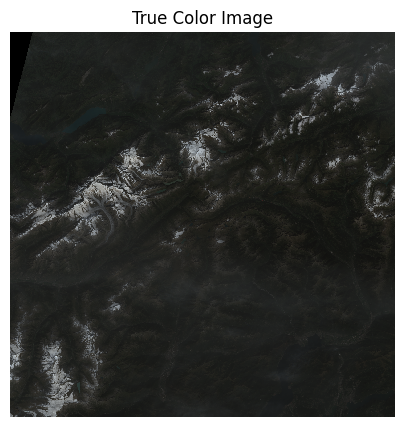

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max value: 1.4127349853515625


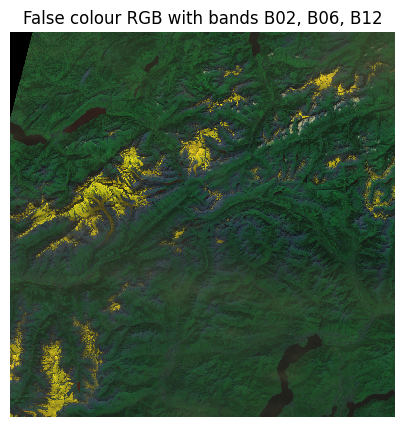

In [93]:
plot_true_color_image(reference_bands['CH'])
plot_rgb_image(reference_bands['CH'], 'B02','B06','B12')

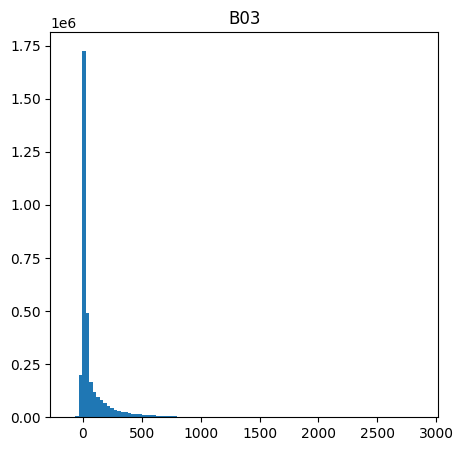

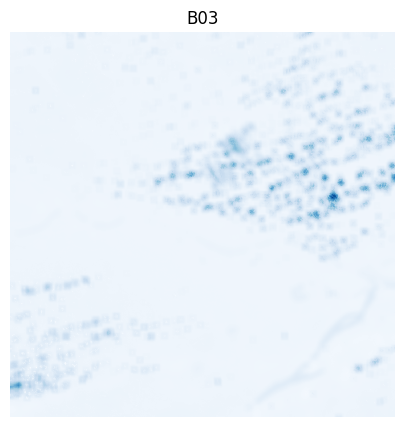

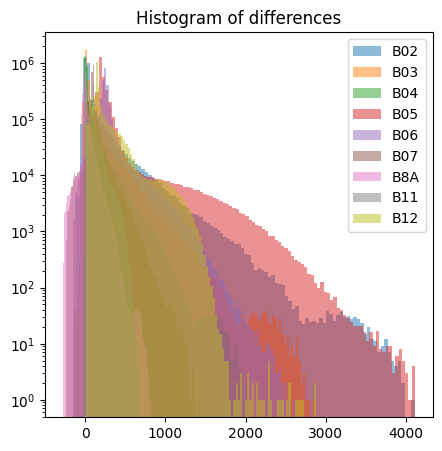

In [94]:
def band_difference_plot(reference, modified, band, color_map="Blues"):
    reference_array = reference[band].read(1).astype(np.float32)
    modified_array = modified[band].read(1).astype(np.float32)
    
    difference_array = reference_array - modified_array

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(
        difference_array,
        interpolation="none",
        cmap=color_map,
    )
    ax.set_title(f"{band}")
    ax.set_axis_off()
    plt.show()



def plot_band_difference_histogram(reference, modified, band):
    reference_array = reference[band].read(1).astype(np.float32).flatten()
    modified_array = modified[band].read(1).astype(np.float32).flatten()
    
    difference_array = reference_array - modified_array
    # current_band = current_band[current_band < 65000]
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.hist(
        difference_array,
        bins=100,
    )
    ax.set_title(f"{band}")
    plt.show()


def plot_difference_histogram(reference, modified, bands):
    bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B8A", "B11", "B12"]
    # bands = ['SCL', 'AOT', 'TCI']
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for band in bands:
        reference_array = reference[band].read(1).astype(np.float32).flatten()
        modified_array = modified[band].read(1).astype(np.float32).flatten()
    
        difference_array = reference_array - modified_array

        ax.hist(
            difference_array,
            bins=100,
            alpha=0.5,
            label=band,
        )
    ax.set_title(f"Histogram of differences")
    ax.set_yscale("log")
    ax.legend()
    plt.show()

loc = 'BRA'
plot_band_difference_histogram(reference_bands[loc], modified_bands[loc]['class_CLOUD_SHADOWS'], 'B03')
band_difference_plot(reference_bands[loc], modified_bands[loc]['class_CLOUD_SHADOWS'], 'B03', color_map='Blues')
plot_difference_histogram(reference_bands[loc], modified_bands[loc]['class_CLOUD_SHADOWS'], bands)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max value: 0.9990009990009991


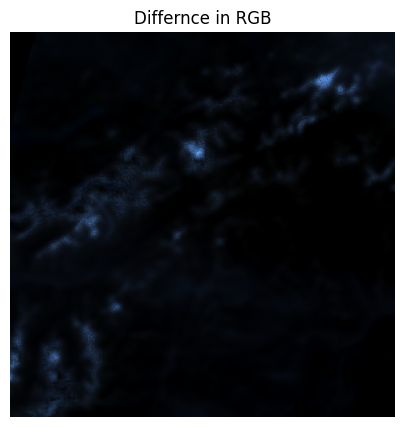

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max value: 1.13018798828125


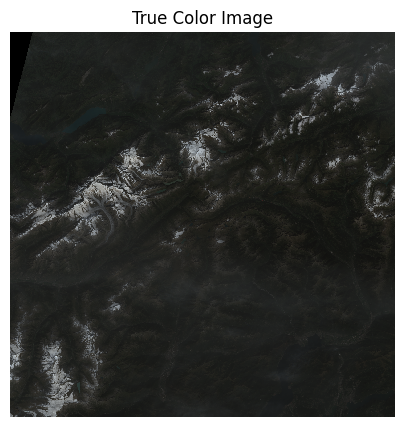

In [95]:
#plot rgb differnce between reference and modified
brightness = 5.0
loc = 'CH'
blue = reference_bands[loc]['B02'].read(1).astype(np.float32) - modified_bands[loc]['class_CLOUD_SHADOWS']['B02'].read(1).astype(np.float32)
green = reference_bands[loc]['B03'].read(1).astype(np.float32) - modified_bands[loc]['class_CLOUD_SHADOWS']['B03'].read(1).astype(np.float32)
red = reference_bands[loc]['B04'].read(1).astype(np.float32) - modified_bands[loc]['class_CLOUD_SHADOWS']['B04'].read(1).astype(np.float32)

blue = blue * brightness / 65536
green = green * brightness / 65536
red = red * brightness / 65536

rgb = np.dstack((red, green, blue))
max_val = np.max(rgb)
# scale up
rgb = rgb / (max_val*1.001)
print(f"Max value: {np.max(rgb)}")
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(
    rgb,
    interpolation="none",
)
ax.set_title("Differnce in RGB")
ax.set_axis_off()
plt.show()

plot_true_color_image(reference_bands[loc])


### Statistical Overview

In [96]:
# find the std div, mean and max of the difference between reference and modified for each band
loc = 'ALG'
def get_stats(reference, modified, bands):
    cols = ['mean','std','max', 'min']
    stats = pd.DataFrame(columns=cols)
    for band in bands:
        current_band = reference[band].read(1).flatten().astype(np.float32) - modified[band].read(1).flatten().astype(np.float32)
        stats.loc[band] = [np.mean(current_band),np.std(current_band),np.max(current_band),np.min(current_band)]
    return stats

stats = get_stats(reference_bands[loc], modified_bands[loc]['class_CLOUD_SHADOWS'], bands)
print(stats)

            mean         std     max     min
B01     0.000000    0.000000     0.0     0.0
B02     0.000000    0.000000     0.0     0.0
B03     0.000000    0.000000     0.0     0.0
B04     0.000000    0.000000     0.0     0.0
B05   625.455444  112.402390  1015.0   184.0
B06   364.301178   64.460976   569.0   112.0
B07   107.891228   17.525696   160.0    38.0
B8A     0.000000    0.000000     0.0     0.0
B09  4470.290527  859.113892  6418.0  1120.0
B11   272.160858   40.634365   373.0   102.0
B12   903.249146  143.813370  1252.0   243.0
AOT     0.000000    0.000000     0.0     0.0
SCL     1.999999    0.000946     2.0     1.0
TCI     0.000000    0.000000     0.0     0.0
WVP  2248.038086   67.769012  2469.0  1952.0
